#Forest cover type prediction
####Doug Kelley, Mandeepak Singh, Rosalind Lee, Kevin Allen

The first thing we need to do is load some Python packages and read in the data.

In [2]:
import pandas as pd
from sklearn import ensemble
from sklearn import tree
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import Imputer
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
import string
sns.set_context('notebook')

In [46]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

There are 7 cover types -- how many of each example do we have in the training set? Many of the classifiers in scikit-learn work better if there is an equal distribution of classes. The chart below shows that this dataset is almost perfectly distributed between the cover types.

2160


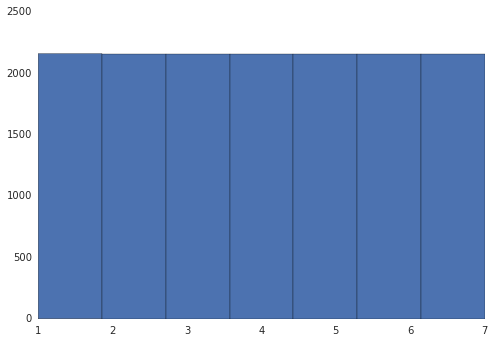

In [221]:
print (train.shape[0]//7)
train['Cover_Type'].hist(bins=7)

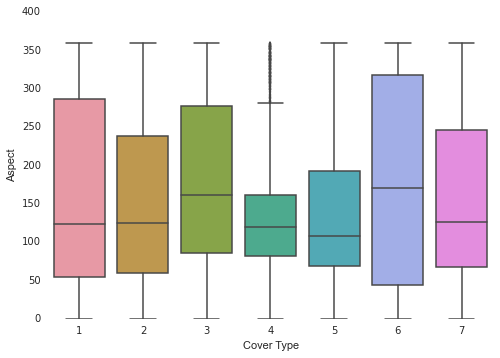

In [222]:
aspectList=[[],[],[],[],[],[],[]]
for k in range(train.shape[0]):
    aspectList[train.ix[k,'Cover_Type']-1].append(train.ix[k,'Aspect'])

sns.boxplot(aspectList)
plt.xlabel('Cover Type')
plt.ylabel('Aspect')

Aspect doesn't really tell us a whole lot -- Cover Type 4 falls in a smaller range than the others but not much spread

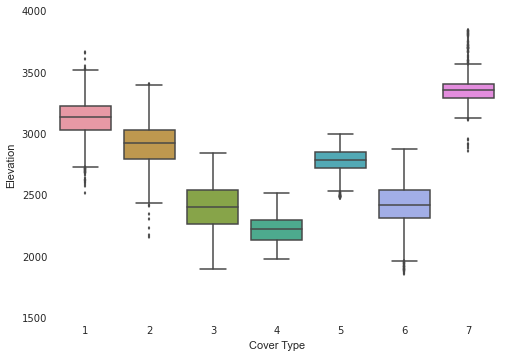

In [223]:
elevationList=[[],[],[],[],[],[],[]]
for k in range(train.shape[0]):
    elevationList[train.ix[k,'Cover_Type']-1].append(train.ix[k,'Elevation'])

sns.boxplot(elevationList)
plt.xlabel('Cover Type')
plt.ylabel('Elevation')

Looks like there's some clear clustering of cover types vs elevation

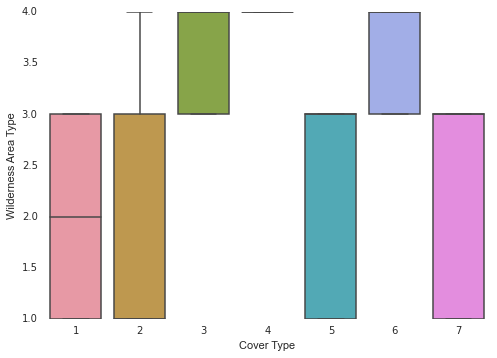

In [224]:
def decodeWA(dataset, index):
    if dataset.ix[index,'Wilderness_Area1'] == 1:
        return 1
    elif dataset.ix[index,'Wilderness_Area2'] == 1:
        return 2
    if dataset.ix[index,'Wilderness_Area3'] == 1:
        return 3
    if dataset.ix[index,'Wilderness_Area4'] == 1:
        return 4
    
waList=[[],[],[],[],[],[],[]]
for k in range(train.shape[0]):
    waList[train.ix[k,'Cover_Type']-1].append(decodeWA(train,k))

sns.boxplot(waList)
plt.xlabel('Cover Type')
plt.ylabel('Wilderness Area Type')
# TODO -- are there covertypes that do NOT show up at all in particular wilderness areas?

Look at combining waList and Elevation

([<matplotlib.axis.XTick at 0x12dc18dd0>,
 <a list of 4 Text xticklabel objects>)

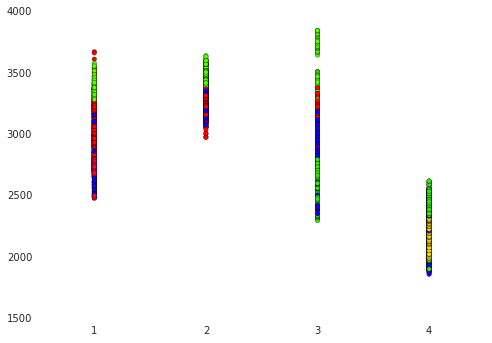

In [236]:
elevations=train.ix[:,'Elevation']
waCode=[]
for k in range(train.shape[0]):
    waCode.append(decodeWA(train,k))
plt.scatter(waCode, elevations, c=train.ix[:,'Cover_Type'],cmap='prism')
plt.xticks([1,2,3,4])

But the wilderness area codes might be tied to elevation and this might not be providing any new information, although clearly Wilderness_Area 4 is different

In [241]:
train.ix[:3,:11]

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
0,1,2596,51,3,258,0,510,221,232,148,6279
1,2,2590,56,2,212,-6,390,220,235,151,6225
2,3,2804,139,9,268,65,3180,234,238,135,6121
3,4,2785,155,18,242,118,3090,238,238,122,6211


Plot histograms of the non-binary features.

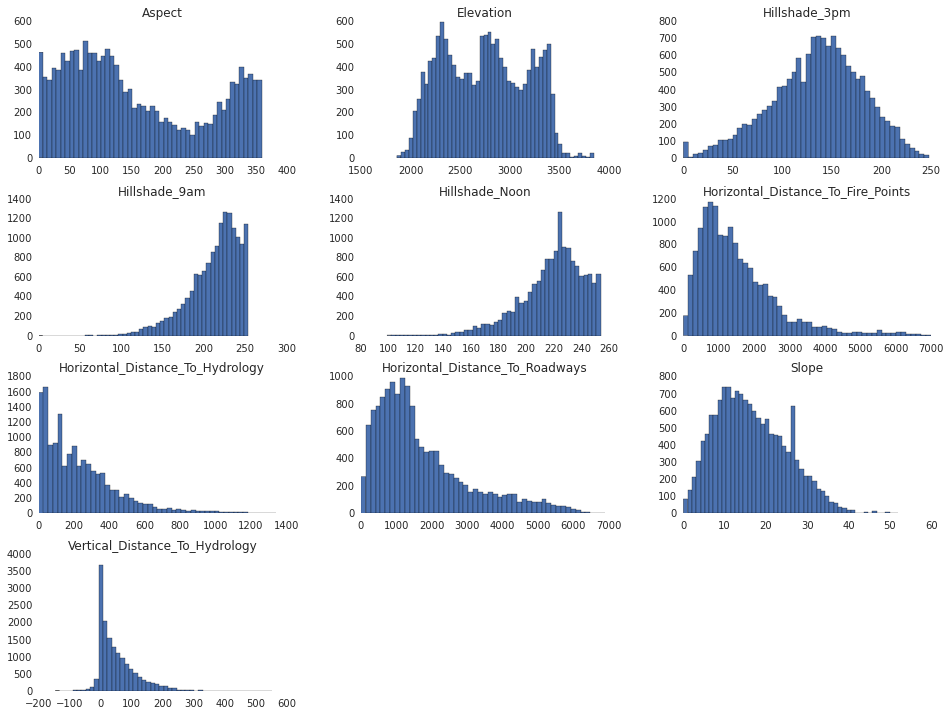

In [242]:
train.ix[:,1:11].hist(figsize=(16,12),bins=50)
plt.show()

Establish a baseline score using the default sklearn decision tree classifier. This had an accuracy of **0.66468** on Kaggle. 

In [4]:
def getImportance(classifier,covariates,title):
    """ Create a chart of feature importances given a tree classifier."""

    importances = classifier.feature_importances_
    std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)
    indices=np.argsort(importances)[::-1][:10]
    # Plot the feature importances of the forest
    plt.figure()
    plt.title(title,fontsize=15)
    plt.bar(range(10), importances[indices],
       yerr=std[indices], align="center",alpha=.5,color="BrBG")
    plt.xticks(range(10), np.asarray(covariates)[indices], rotation=45, rotation_mode="anchor", ha="right")
    plt.xlim([-1, 10])
    plt.show()


In [244]:
feature_cols = [col for col in train.columns if col not in ['Cover_Type','Id']]

X_train = train[feature_cols]
X_test = test[feature_cols]
y = train['Cover_Type']
test_ids = test['Id']

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y)

with open("decision_tree_baseline.csv", "wt") as outfile:
    outfile.write("Id,Cover_Type\n")
    for e, val in enumerate(list(clf.predict(X_test))):
        outfile.write("%s,%s\n"%(test_ids[e],val))


Using Random Forest Classifier on the data had an accuracy of >70% on Kaggle. The chart of feature importances shows that the elevation and distance features weight heavily on the outcome. These will be good targets for feature engineering.

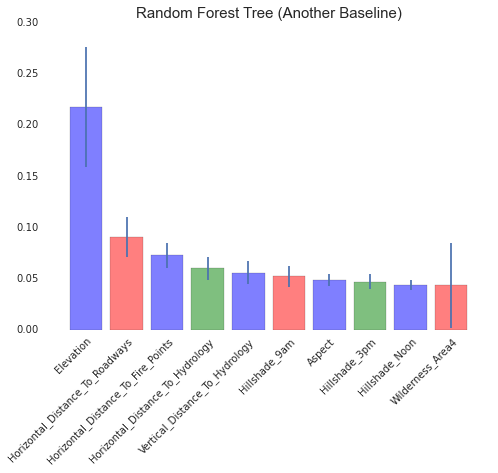

In [245]:
randf = RandomForestClassifier(n_estimators=100, bootstrap=True, oob_score=True)
feature_cols = [col for col in train.columns if col not in ['Cover_Type','Id']]

X_train = train[feature_cols]
X_test = test[feature_cols]
y = train['Cover_Type']
test_ids = test['Id']
randf.fit(X_train, y)
getImportance(randf, list(feature_cols), "Random Forest Tree (Another Baseline)") 


Scatter Plot for top 5 features

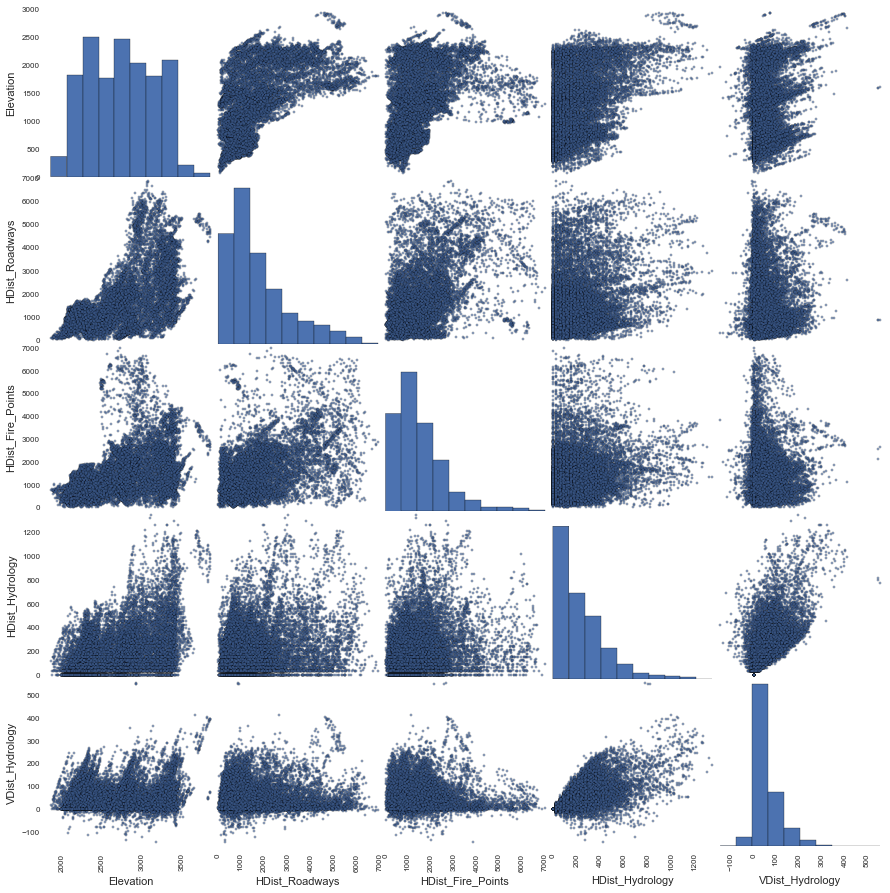

In [127]:
top5=train[['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology']]
top5.columns=top5.columns.map(lambda x: x.replace('Horizontal_Distance_To','HDist'))
top5.columns=top5.columns.map(lambda x: x.replace('Vertical_Distance_To','VDist'))
scatter_matrix(top5,figsize=(15, 15),alpha=.6)
plt.show()

That the Horizontal Distance to Roadways increases with Elevation should come as little surprise -- at higher elevations fewer roads will be built. Otherwise the only clear trend is that horizontal and vertical distances to hydrology appear correlated. We can use this information to create a new feature, which is just the straight line distance from the plot to the water table.

Thanks to [Alexander Gushkin][link1] for the feature ideas.

[link1]: http://nbviewer.ipython.org/github/aguschin/kaggle/blob/master/forestCoverType_featuresEngineering.ipynb

In [100]:
train['Distance_to_Hydrology'] = (train['Horizontal_Distance_To_Hydrology']**2+train['Vertical_Distance_To_Hydrology']**2)**0.5
test['Distance_to_Hydrology'] = (test['Horizontal_Distance_To_Hydrology']**2+test['Vertical_Distance_To_Hydrology']**2)**0.5

For more feature ideas, looking at plots of the features against each other helps. Here is the graph of Elevation versus Horizontal_Distance_to_Hydrology color coded by cover type.

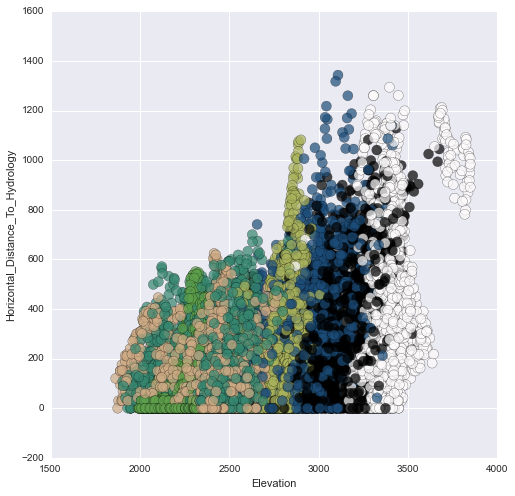

In [172]:
# function to plot two features against each other to look for correlations
def plotc(c1,c2):

    fig = plt.figure(figsize=(8,8))
    sel = np.array(list(train.Cover_Type.values))
    plt.scatter(c1, c2, c=sel, s=100,cmap=plt.cm.gist_earth,alpha=.7)
    plt.ylabel(c2.name)
    plt.xlabel(c1.name)
    
plotc(train.Elevation, train.Horizontal_Distance_To_Hydrology)

Create two features: difference between Elevation and Vertical Distance to Hydrology and difference between Elevation and one-fifth of the Horizontal Distance to Hydrology. 

In [99]:
train['EVDtH'] = train.Elevation-train.Vertical_Distance_To_Hydrology
test['EVDtH'] = test.Elevation-test.Vertical_Distance_To_Hydrology

train['EHDtH'] = train.Elevation-train.Horizontal_Distance_To_Hydrology*0.2
test['EHDtH'] = test.Elevation-test.Horizontal_Distance_To_Hydrology*0.2

Plot the difference between Elevation and one-fifth of the Horizontal Distance to Hydrology versus Horizontal Distance to Hydrology.

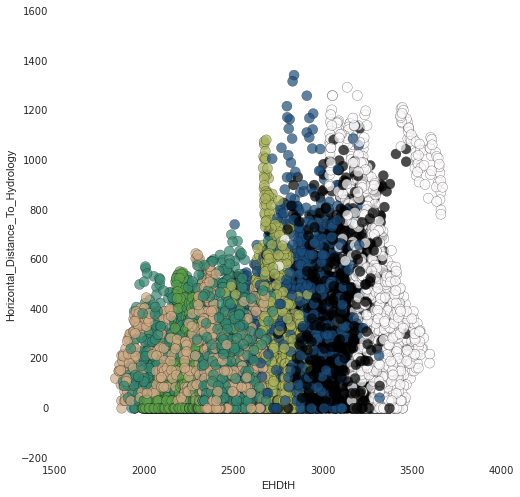

In [251]:
plotc(train.EHDtH, train.Horizontal_Distance_To_Hydrology)

The cover type classes now appear to be a little more linearly separable by the new feature.

These are some additional features that were suggested by Gushkin.

In [101]:
train['Hydro_Fire_1'] = train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Fire_Points']
test['Hydro_Fire_1'] = test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Fire_Points']

train['Hydro_Fire_2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Fire_Points'])
test['Hydro_Fire_2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Fire_Points'])

train['Hydro_Road_1'] = abs(train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Roadways'])
test['Hydro_Road_1'] = abs(test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Roadways'])

train['Hydro_Road_2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Roadways'])
test['Hydro_Road_2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Roadways'])

train['Fire_Road_1'] = abs(train['Horizontal_Distance_To_Fire_Points']+train['Horizontal_Distance_To_Roadways'])
test['Fire_Road_1'] = abs(test['Horizontal_Distance_To_Fire_Points']+test['Horizontal_Distance_To_Roadways'])

train['Fire_Road_2'] = abs(train['Horizontal_Distance_To_Fire_Points']-train['Horizontal_Distance_To_Roadways'])
test['Fire_Road_2'] = abs(test['Horizontal_Distance_To_Fire_Points']-test['Horizontal_Distance_To_Roadways'])

Hill Shade Scatter Plot - There is a clear negative correlation between Hillshade_9am and Hillshade_3pm, which would make sense for a west-facing slope in Colorado.

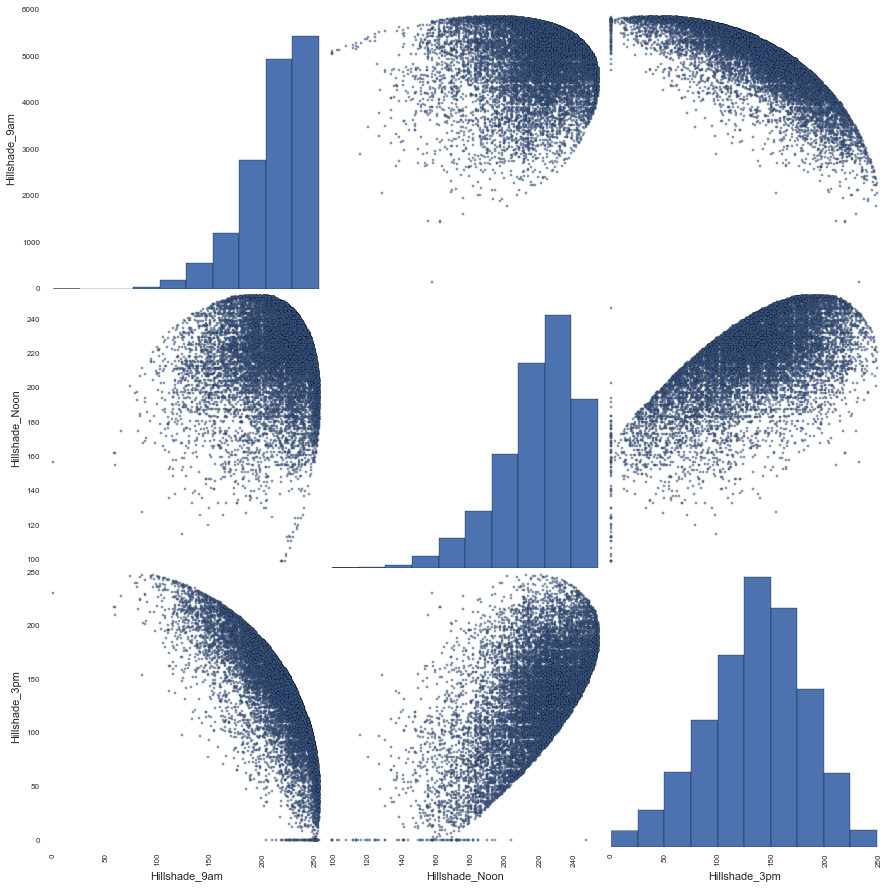

In [253]:
hill_shade = train[['Hillshade_9am', 'Hillshade_Noon','Hillshade_3pm']] 
scatter_matrix(hill_shade, alpha=0.6, figsize=(15, 15))
plt.show()

Plot the Hillshade at 3 p.m. values versus Hillshade at 12 p.m. There are Hillshade at 3 p.m. values that are zero.

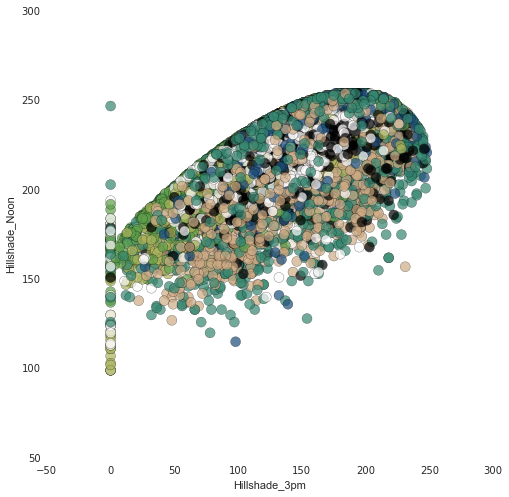

In [254]:
plotc(train.Hillshade_3pm, train.Hillshade_Noon)

Clearly, there are hillshade 3pm values that are zero

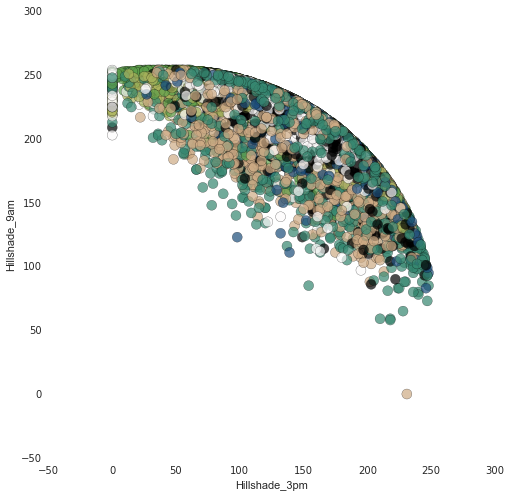

In [255]:
plotc(train.Hillshade_3pm, train.Hillshade_9am)

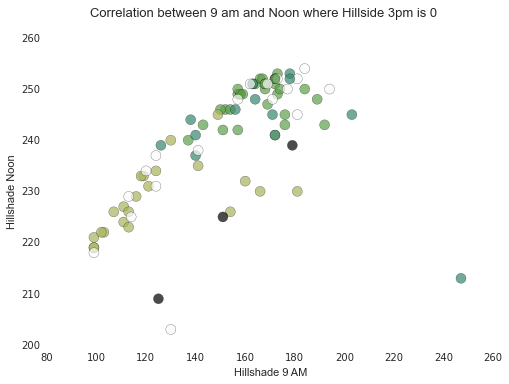

In [256]:
Hill_shade_3pm_missing=train[train.Hillshade_3pm==0]
sel = np.array(list(Hill_shade_3pm_missing.Cover_Type.values))
plt.scatter(Hill_shade_3pm_missing.Hillshade_Noon, Hill_shade_3pm_missing.Hillshade_9am, c=sel, s=100,cmap=plt.cm.gist_earth,alpha=.7)
plt.suptitle('Correlation between 9 am and Noon where Hillside 3pm is 0', fontsize=13)
plt.xlabel('Hillshade 9 AM') 
plt.ylabel('Hillshade Noon')


plt.show()

In [259]:
hillshadeBad3pmId = train[train.Hillshade_3pm == 0.0].Id

In [260]:
hillshadeBad3pmId.shape

(88,)

In [261]:
print train.Hillshade_Noon[hillshadeBad3pmId][:10]
# maybe replace with the average of samples with the same noon hillshade

Id
1376    235
1412    227
1417    183
1420    239
1424    166
1425    224
1428    183
1432    205
1440    160
1441    223
Name: Hillshade_Noon, dtype: int64


Using Median Values to fill missing values for Hillshade_3pm

In [262]:
temp=train.copy()
cols=temp.columns.tolist()
cols=cols[:8]+cols[9:]+[cols[8]]
temp=temp[cols]
del temp['Cover_Type']

X,y,X_train_data_missing,y_train_data_missing= temp[temp.Hillshade_3pm!=0].values[:,:-1],temp[temp.Hillshade_3pm!=0].values[:,-1:].ravel(),temp[temp.Hillshade_3pm==0].values[:,:-1],temp[temp.Hillshade_3pm==0].values[:,-1:].ravel()


X_train,X_test,y_train,y_test=train_test_split(X,y)
imp = Imputer(missing_values='NaN', strategy='median', axis=1)
imp.fit(X_train,y_train)
temp.Hillshade_3pm.loc[temp.Hillshade_3pm==0]=imp.transform(X_train_data_missing)
train.Hillshade_3pm=temp.Hillshade_3pm


temp=test.copy()
cols=temp.columns.tolist()
cols=cols[:8]+cols[9:]+[cols[8]]
temp=temp[cols]


X_test_data_missing= temp[temp.Hillshade_3pm==0].values[:,:-1]
temp.Hillshade_3pm.loc[temp.Hillshade_3pm==0]=imp.transform(X_test_data_missing)
test.Hillshade_3pm=temp.Hillshade_3pm


We have a bunch of features that were created from other features. By removing some of the redundancy, we can simplify the resulting tree. Because we already have all the information about horizontal and vertical distances to hydrology in the straight line distance, we will remove the two original features. 

In [102]:
feature_cols = [col for col in train.columns if col not in ['Cover_Type','Id','Horizontal_Distance_To_Hydrology',
                                                            'Vertical_Distance_To_Hydrology']]

X_train = train[feature_cols]
X_test = test[feature_cols]
y = train['Cover_Type']
test_ids = test['Id']

forest = ensemble.ExtraTreesClassifier(n_estimators=400, criterion='gini', max_depth=None, 
    min_samples_split=2, min_samples_leaf=1, max_features='auto', 
    bootstrap=False, oob_score=False, n_jobs=-1, random_state=None, verbose=0)


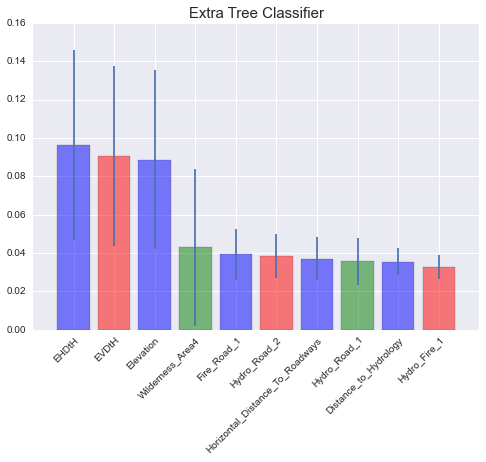

In [218]:
forest.fit(X_train, y)
getImportance(forest, list(X_train), "Extra Tree Classifier") 
with open('FEbenchmark2.csv', "wt") as outfile:
    outfile.write("Id,Cover_Type\n")
    for e, val in enumerate(list(forest.predict(X_test))):
        outfile.write("%s,%s\n"%(test_ids[e],val))

This version scored an accuracy of **0.81259** on Kaggle. There was a pretty big improvement by eliminating a couple features. The same tree with the two extra distance features scored 0.80856. 

By adding a couple more features, we can try to improve this score even further. Aspect essentially measures direction that the plot is facing, assuming there is slope. For example, 0 degrees aspect is a north facing plot, and 360 degrees aspect is also a north facing plot. This discontinuity can be resolved by creating a new measure that indicates the number of degrees from south facing.

In [205]:
# prevent pandas from displaying a warning message
pd.options.mode.chained_assignment = None
train['south_face'] = [180 - a if a <=180 else a - 180  for a in X_train.Aspect]
test['south_face']= [180 - a if a <=180 else a - 180  for a in X_test.Aspect]

The effect of sunlight and temperature on northernly facing hillsides is amplified by the slope, [according to Wikipedia][link2]. We can get a measure of this effect by looking at the interaction of our south facing feature and the slope feature.

[link2]:http://en.wikipedia.org/wiki/Aspect_

In [206]:
train['south_x_slope'] = X_train.south_face * X_train.Slope
test['south_x_slope'] = X_test.south_face * X_test.Slope

Adding these additional features results in a big decrease in the score, to **0.80366**. It looks like it pays to keep things simple. We found out that feature engineering is difficult and time consuming. A valuable lesson is that if you combine features such that all information is captured in the new feature, then removing the original features may be a good thing, at least if you are training trees. This generalization doesn't appear to hold if the new features are not a perfect representation of the original features. For example, despite creating several features that use the elevation as a key component, removing the elevation from the final training set resulted in a worse score. 

In [220]:
feature_cols = [col for col in train.columns if col not in ['Cover_Type','Id','Horizontal_Distance_To_Hydrology',
                                                            'Vertical_Distance_To_Hydrology', 'south_face', 
                                                            'south_x_slope']]

X_train = train[feature_cols]
X_test = test[feature_cols]

We have gotten quite a bit out of a single classifier, so the next logical step is to look at combining classifiers to see if the result will get any better. The first ensemble we will evaluate is a bagging ensemble that just takes a majority vote. To say that another way, we take the predictions from several classifiers for a given row of data, then pick the class that is most commonly chosen by the classifiers. The algorithm breaks ties by looking at the classifiers' accuracies on the training set. The method is a little flawed, because it would be skewed by classifiers that overfit the training data. However, because we are using random trees with a lot of estimators, we don't have to worry too much about overfitting. 

Before we begin building the ensemble, first we need to do some grid searching to find the optimal parameters for our classifiers.

In [230]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
start = time.time()

params = {'max_features':['auto',9,10,11,12]}

clf = GridSearchCV(RandomForestClassifier(criterion='gini',n_estimators=100),params)
clf.fit(X_train, y)
print 'Criterion: gini'
print clf.best_score_
print clf.best_params_
print clf.grid_scores_

params = {'max_features':['auto',12,13,14,15]}

clf = GridSearchCV(RandomForestClassifier(criterion='entropy',n_estimators=100),params)
clf.fit(X_train, y)
print 'Criterion: entropy'
print clf.best_score_
print clf.best_params_
print clf.grid_scores_
print 'Run time = %s' % (datetime.timedelta(seconds=time.time() - start))

Criterion: gini
0.806481481481
{'max_features': 'auto'}
[mean: 0.80648, std: 0.01868, params: {'max_features': 'auto'}, mean: 0.80298, std: 0.02012, params: {'max_features': 9}, mean: 0.80311, std: 0.02033, params: {'max_features': 10}, mean: 0.80556, std: 0.02127, params: {'max_features': 11}, mean: 0.80509, std: 0.01849, params: {'max_features': 12}]
Criterion: entropy
0.805291005291
{'max_features': 13}
[mean: 0.80403, std: 0.02198, params: {'max_features': 'auto'}, mean: 0.80298, std: 0.02125, params: {'max_features': 12}, mean: 0.80529, std: 0.01934, params: {'max_features': 13}, mean: 0.80344, std: 0.02073, params: {'max_features': 14}, mean: 0.80152, std: 0.01769, params: {'max_features': 15}]
Run time = 0:01:49.720427


The default parameters seem to work best for the gini decision criterion (this time...), but for the entropy criterion we should increase the number of max features that are searched before each split. By increasing the max_features from 7 (default) to 13, we get a better estimate and we also reduce the standard deviation of the accuracy.

In [231]:
# combine estimators to get better result
# use bagging first, which gets a majority vote
# each estimator trained on different subset, works best with fully developed classifiers as 
# opposed to boosting which works best with shallow classifiers

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
import datetime
import time

def custom_bagging_ensemble(X_train, y_train, X_test, y_test=None):
    start = time.time()
    scores = []
    
    rfg_params = { 'n_estimators':400, 'n_jobs':-1, 'criterion':'gini', 'max_features':'auto' }
    rfe_params = { 'n_estimators':400, 'n_jobs':-1, 'criterion':'entropy', 'max_features':13 }
    et_params = { 'n_estimators':400, 'n_jobs':-1 }
    
    clfs = [RandomForestClassifier(**rfg_params),
            RandomForestClassifier(**rfe_params),
            ExtraTreesClassifier(criterion='gini',**et_params),
            ExtraTreesClassifier(criterion='entropy',**et_params),
            KNeighborsClassifier()]
    
    predictions = np.zeros((X_test.shape[0], len(clfs)))
    scores = np.zeros((1, len(clfs)))
    
    for i, clf in enumerate(clfs):
        clf.fit(X_train, y_train)
        predictions[:,i] = clf.predict(X_test)
        scores[0,i] = clf.score(X_train, y_train)
    
    # combine all the votes using equal weights (tie break
    # uses train set accuracy)
    final_predictions = []

    for votes in predictions:
        # count up the number of votes for each cover type
        covertypes = [0,0,0,0,0,0,0]
        # keep track of the combined accuracy of the classifiers that voted 
        # for a particular cover type
        clf_accuracy = [0,0,0,0,0,0,0]
        
        for clf, vote in enumerate(votes):
            covertypes[int(vote)-1] += 1
            clf_accuracy[int(vote)-1] += scores[:,clf].ravel()
        # determine highest number of votes for single cover type
        max_votes = max(covertypes)
        # find indices of types with most votes, while accounting for 
        # more than 1 cover type tied for most votes
        most_voted_types = [i for i,vote in enumerate(covertypes) if vote == max_votes]
        if len(most_voted_types) > 1:
            accuracies = [acc for i,acc in enumerate(clf_accuracy) if i in most_voted_types]
            prediction = most_voted_types[accuracies.index(max(accuracies))] + 1
            final_predictions.append(prediction)
            continue
        final_predictions.append(most_voted_types[0]+1) 

    print 'Prediction time: %s' % (datetime.timedelta(seconds=time.time() - start))  
    return final_predictions, all_votes

# run on a subset of data to test ensemble
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train.ix[:,].values, 
                                                        y.ix[:,].values.ravel(),
                                                        test_size=0.20)

dev_pred, all_votes = custom_bagging_ensemble(X_train_, y_train_, X_test_, y_test_)

score = 1.0*sum([1 if label == pred else 0 for label, pred \
                 in zip(y_test_, dev_pred)])/len(y_test_)
print 'Bagging ensemble accuracy:', score

Prediction time: 0:00:13.369373
Bagging ensemble accuracy: 0.902447089947


In [233]:
# generate prediction from bagging ensemble
import csv

predictions,_ = custom_bagging_ensemble(X_train, y, X_test)

with open("baggingensemble.csv", "wb") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Id','Cover_Type'])
    for id, prediction in zip(test_ids, predictions):
        writer.writerow([int(id), int(prediction)])

Prediction time: 0:01:23.924281


The bagging ensemble does not perform as well as the single extra trees classifier, with a result of **0.80673**. This might come as no surprise, as the random forests were performing much worse than the extra trees when doing cross-validation. Let's try to add another classifer to introduce some variability into these estimates. We will use a nearest neighbors algorithm, which seemed to perform well in early testing. Nearest neighbors works much better with a lower dimensionality feature set (for our data). We can try to pick the best columns by eliminating those that don't improve the score.

The column indexes to keep are [0, 1, 2, 3, 4, 5, 6, 7, 9, 14, 15, 23]
1NN accuracy: 0.862103174603


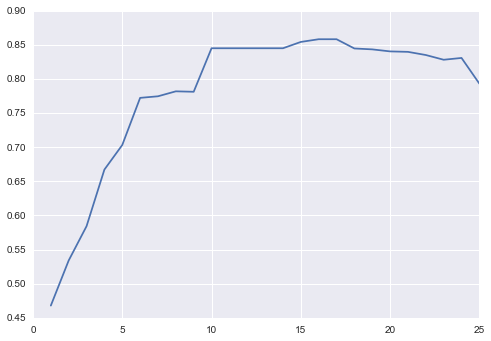

In [289]:
# figure out which features to use with nearest neighbors

# removing the soil type columns result in a big improvement for kNN
minus_soil_feats = [col for col in train.columns if "Soil_Type" not in col]
X_train_knn = train[minus_soil_feats]
feature_cols = [col for col in X_train_knn.columns if col not in ['Cover_Type', 'Id']]
X_train_knn = X_train_knn[feature_cols]
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train_knn.ix[:,].values, 
                                                         y.ix[:,].values.ravel(),
                                                         test_size=0.20)

cols = X_train_knn.columns
knn = KNeighborsClassifier(n_neighbors=1)
scores = []
for n in range(1,len(cols)+1):
    knn.fit(X_train_[:,0:n],y_train_)
    score = knn.score(X_test_[:,0:n], y_test_)
    scores.append(score)

plt.plot(range(1,len(cols)+1), scores)

# keeping elevation to seed the process
cols_to_keep = [0]
for i in range(len(scores)-1):
    if scores[i+1] - scores[i] > 0:
        cols_to_keep.append(i + 1)

print 'The column indexes to keep are', cols_to_keep

knn.fit(X_train_[:,cols_to_keep], y_train_)
print '1NN accuracy:', knn.score(X_test_[:,cols_to_keep], y_test_)

The new ensemble is the same as the last one, with the addition of the 1-NN classifier.

In [290]:
def custom_bagging_ensemble2(X_train, y_train, X_test, y_test=None):
    start = time.time()
    scores = []
    
    rfg_params = { 'n_estimators':400, 'n_jobs':-1, 'criterion':'gini', 'max_features':'auto' }
    rfe_params = { 'n_estimators':400, 'n_jobs':-1, 'criterion':'entropy', 'max_features':13 }
    et_params = { 'n_estimators':400, 'n_jobs':-1 }
    
    clfs = [RandomForestClassifier(**rfg_params),
            RandomForestClassifier(**rfe_params),
            ExtraTreesClassifier(criterion='gini',**et_params),
            ExtraTreesClassifier(criterion='entropy',**et_params),
            KNeighborsClassifier(n_neighbors=1)]
    
    predictions = np.zeros((X_test.shape[0], len(clfs)))
    scores = np.zeros((1, len(clfs)))
    
    for i, clf in enumerate(clfs):
        # need to handle the kNN classifier a little differently,
        # only keep a couple columns
        if isinstance(clf,KNeighborsClassifier):
            clf.fit(X_train[:,cols_to_keep], y_train)
            predictions[:,i] = clf.predict(X_test[:,cols_to_keep])
            scores[0,i] = clf.score(X_train[:,cols_to_keep], y_train)
        clf.fit(X_train, y_train)
        predictions[:,i] = clf.predict(X_test)
        scores[0,i] = clf.score(X_train, y_train)
    
    # combine all the votes using equal weights (tie break
    # uses train set accuracy)
    final_predictions = []

    for votes in predictions:
        # count up the number of votes for each cover type
        covertypes = [0,0,0,0,0,0,0]
        # keep track of the combined accuracy of the classifiers that voted 
        # for a particular cover type
        clf_accuracy = [0,0,0,0,0,0,0]
        
        for clf, vote in enumerate(votes):
            covertypes[int(vote)-1] += 1
            clf_accuracy[int(vote)-1] += scores[:,clf].ravel()
        # determine highest number of votes for single cover type
        max_votes = max(covertypes)
        # find indices of types with most votes, while accounting for 
        # more than 1 cover type tied for most votes
        most_voted_types = [i for i,vote in enumerate(covertypes) if vote == max_votes]
        # when there is a tie, uses training set accuracy as a tie break
        if len(most_voted_types) > 1:
            accuracies = [acc for i,acc in enumerate(clf_accuracy) if i in most_voted_types]
            prediction = most_voted_types[accuracies.index(max(accuracies))] + 1
            final_predictions.append(prediction)
            continue
        final_predictions.append(most_voted_types[0]+1) 

    print 'Prediction time: %s' % (datetime.timedelta(seconds=time.time() - start))  
    return final_predictions, all_votes

# run on a subset of data to test ensemble
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train.ix[:,].values, 
                                                        y.ix[:,].values.ravel(),
                                                        test_size=0.20)

dev_pred, all_votes = custom_bagging_ensemble2(X_train_, y_train_, X_test_, y_test_)

score = 1.0*sum([1 if label == pred else 0 for label, pred \
                 in zip(y_test_, dev_pred)])/len(y_test_)
print 'Bagging ensemble accuracy:', score

Prediction time: 0:00:14.037531
Bagging ensemble accuracy: 0.910383597884


In [296]:
# generate prediction from bagging ensemble
predictions,_ = custom_bagging_ensemble2(X_train.as_matrix(), y.as_matrix(), 
                                         X_test.as_matrix())

with open("baggingensemble2.csv", "wb") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Id','Cover_Type'])
    for id, prediction in zip(test_ids, predictions):
        writer.writerow([int(id), int(prediction)])

Prediction time: 0:01:39.135666


The new ensemble performed even worse than the other one, with an accuracy of **0.80340**. This result seems to be about a single standard deviation away from the previous result, based on the grid search score for the random forests. So it is not entirely clear whether the ensemble was worse or if the variation we are seeing is due to chance.

The next type of ensemble we will test is a stacking ensemble. This code was adapted from an example posted by [Emanuele Olivetti][link3]. We are going to stick to decision trees for this one because they seem to provide the best accuracy. After we generate predictions for each row in the dataset, we will use those predictions to make a final prediction on the class. The final "blending" classifier was chosen to be an Extra Trees Classifier, because it can account for pecularities in the dataset, as opposed to logistic regression, another popular choice for blending, which would only predict some linear combination of the predictions of the original classifiers. It was found that logistic regression pretty much just weighted one of the extra tree classifiers so that our final decision was just the output of a single classifier. With the randomness of our extra trees blending classifier, the weights are much more evenly distributed between the inputs.

[link3]:https://github.com/emanuele/kaggle_pbr/blob/master/blend.py

In [303]:

from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

def custom_stacking_ensemble(X_train, y_train, X_test, y_test=None):
    start = time.time()
    n_folds = 10
    skf = list(StratifiedKFold(y_train, n_folds))
    
    rfg_params = { 'n_estimators':400, 'n_jobs':-1, 'criterion':'gini', 'max_features':'auto' }
    rfe_params = { 'n_estimators':400, 'n_jobs':-1, 'criterion':'entropy', 'max_features':13 }
    et_params = { 'n_estimators':400, 'n_jobs':-1 }
    
    clfs = [RandomForestClassifier(**rfg_params),
            RandomForestClassifier(**rfe_params),
            ExtraTreesClassifier(criterion='gini',**et_params),
            ExtraTreesClassifier(criterion='entropy',**et_params)]
    
    train_votes = np.zeros((X_train.shape[0], len(clfs)))
    test_votes = np.zeros((X_test.shape[0], len(clfs)))
    
    for i, clf in enumerate(clfs):
        votes = np.zeros((X_test.shape[0], len(skf)))
        for j, (train_indices, test_indices) in enumerate(skf):
            # create train and test sets based on cross-validation folds
            X_train_fold = X_train[train_indices]
            y_train_fold = y_train[train_indices]
            X_test_fold = X_train[test_indices]
            y_test_fold = y_train[test_indices]
            clf.fit(X_train_fold, y_train_fold)
            # each training example will be a part of the test group only once,
            # so we can track the predictions to use later as inputs
            train_votes[test_indices,i] = clf.predict(X_test_fold)
            # votes from each classifier go in a separate column (i.e. feature)
            votes[:,j] = clf.predict(X_test)
        # pick the cover type with most votes
        for k,row in enumerate(votes):
            row = [int(vote) for vote in row]
            # just grab the first one
            test_votes[k,i] = np.argmax(np.bincount(row))
            # TODO: implement a tie break, not many ties so not a priority
            
    clf = ExtraTreesClassifier(n_estimators=400, n_jobs=-1)
    clf.fit(train_votes, y_train)
    
    print 'Prediction time: %s' % (datetime.timedelta(seconds=time.time() - start))
    if y_test is not None:
        print 'Feature importances:', clf.feature_importances_
        print 'Stacking ensemble dev set accuracy:', clf.score(test_votes, y_test)
        
    return clf.predict(test_votes)

# run on a subset of data to test ensemble
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train.ix[:,].values, 
                                                        y.ix[:,].values.ravel(),
                                                        test_size=0.20)

_ = custom_stacking_ensemble(X_train_, y_train_, X_test_, y_test_)

Prediction time: 0:02:01.682589
Stacking ensemble dev set accuracy: 0.907407407407
Feature importances: [ 0.23215296  0.20851099  0.26863279  0.29070326]


In [304]:
# generate prediction from stacking ensemble
predictions = custom_stacking_ensemble(X_train.as_matrix(), y.as_matrix(), X_test.as_matrix())

with open("stackingensemble.csv", "wb") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Id','Cover_Type'])
    for id, prediction in zip(test_ids, predictions):
        writer.writerow([int(id), int(prediction)])

Prediction time: 0:11:40.362787
Feature importances: [ 0.24359543  0.21375577  0.24259317  0.30005563]


It seems futile! This entry scored **0.79382** on Kaggle. Lending more weight to the lower powered classifiers was a losing strategy in this instance. It might have worked better if the classifiers were tending to overfit, in which case being able to generalize better would result in an improvement. The boosting ensemble, which just took a vote to determine the most popular class, performed better than the stacking ensemble, which used a decision tree on the ensemble classifiers' predictions to determine the final, blended prediction.

How well should we be able to do? This is a pretty aggressive train/test split, and it would be helpful to benchmark against the full dataset.

The dataset is available at https://archive.ics.uci.edu/ml/datasets/Covertype

There is also a spark/MLLib implementation and walkthrough at https://github.com/sryza/aas/blob/master/ch04-rdf/src/main/scala/com/cloudera/datascience/rdf/RunRDF.scala 

Let's pull out a subset of this and look at the accuracy of MLLib's RandomForest classifier for different splits

Here's some scala code adapted from the Advanced Analytics in Spark github repo (URL above)

    import org.apache.spark.mllib.evaluation.MulticlassMetrics
    import org.apache.spark.mllib.linalg.Vectors
    import org.apache.spark.mllib.regression.LabeledPoint
    import org.apache.spark.mllib.tree.{RandomForest, DecisionTree}
    import org.apache.spark.mllib.tree.model.DecisionTreeModel
    import org.apache.spark.rdd.RDD
    import org.apache.spark.{SparkConf, SparkContext}
    object RunRDF {

      def main(args: Array[String]): Unit = {
        val sc = new SparkContext(new SparkConf().setAppName("RDF"))
        val rawData = sc.textFile("covtype.data")

        val data = rawData.map { line =>
              val values = line.split(',').map(_.toDouble)
              val featureVector = Vectors.dense(values.init)
              val label = values.last - 1
              LabeledPoint(label, featureVector)
         }

        evaluateForest(rawData)
      }
  
      def unencodeOneHot(rawData: RDD[String]): RDD[LabeledPoint] = {
           rawData.map { line =>
               val values = line.split(',').map(_.toDouble)
                // Which of 4 "wilderness" features is 1
               val wilderness = values.slice(10, 14).indexOf(1.0).toDouble
               // Similarly for following 40 "soil" features
               val soil = values.slice(14, 54).indexOf(1.0).toDouble
               // Add derived features back to first 10
               val featureVector = Vectors.dense(values.slice(0, 10) :+ wilderness :+ soil)
               val label = values.last - 1
               LabeledPoint(label, featureVector)
            }
       }
  
      def evaluateForest(rawData: RDD[String]): Unit = {

          val data = unencodeOneHot(rawData)
          // Vary the train/test split here to look at accuracy entitlement
          val Array(trainData, cvData) = data.randomSplit(Array(0.9, 0.1))
          trainData.cache()
          cvData.cache()

          val forest = RandomForest.trainClassifier(
                 trainData, 7, Map(10 -> 4, 11 -> 40), 20, "auto", "entropy", 30, 300)

          val predictionsAndLabels = cvData.map(example =>
                      (forest.predict(example.features), example.label))
          println(new MulticlassMetrics(predictionsAndLabels).precision)

        }
    }

With a 90/10 split, we get 96.5% accuracy

70/30: 96.0%

50/50: 95.2%

30/70: 94.0%

10/90: 89.5%

5/95: 86.3%

2/98: 81.1%

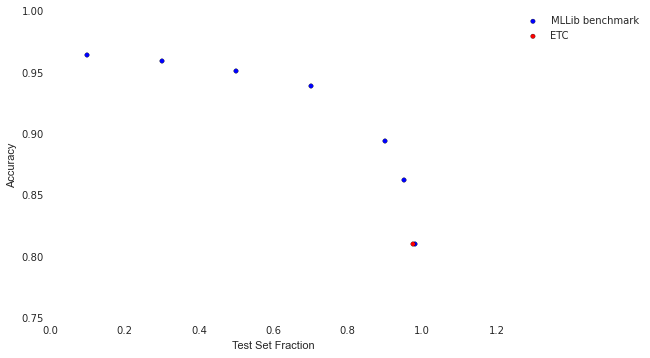

In [273]:
testsplit=[0.1,0.3,0.5,0.7,0.9,0.95,0.98]
rfacc=[0.965,0.960,0.952,0.940,0.895,0.863,0.811]
plt.scatter(testsplit,rfacc, label='MLLib benchmark')
plt.scatter(float(test.shape[0])/float(train.shape[0]+test.shape[0]),0.81108, c='red',label='ETC')
plt.grid()
plt.xlabel('Test Set Fraction')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

This plot indicates that we're doing about as well as we can expect given this train/test split

In [6]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
feature_cols = [col for col in train.columns if col not in ['Cover_Type','Id']]

X_train = train[feature_cols]
X_test = test[feature_cols]
y = train['Cover_Type']
test_ids = test['Id']

# Splitting Training data into Training and Validation
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train.ix[:,].values, y.ix[:,].values.ravel(),test_size=0.20)

def crossvalidation(clf,params,jobs=1):
    ss = ShuffleSplit(X_train_.shape[0], n_iter=10, test_size=0.2)
    classifier = GridSearchCV(estimator=clf, cv=ss, param_grid=params,n_jobs=jobs,scoring="accuracy",refit=True)
    classifier.fit(X_train_, y_train_)
    print("Best Estimator using Grid Search")
    print(classifier.best_estimator_)
    return classifier, classifier.best_estimator_
    
print("Extra Tree Classifier")
print("---------------------")
extra_forest = ensemble.ExtraTreesClassifier(n_estimators=100,bootstrap=True)

params={
    'max_depth': [5,10,15,20],
    }

cv,best_est=crossvalidation(extra_forest, params)
print("Training Score:")
print (best_est.score(X_train_,y_train_))
print("Test Score:")
print (best_est.score(X_test_,y_test_))
print("Test - Classification Report - Extra Tree Classifier")
y_pred_=best_est.predict(X_test_)
print(metrics.classification_report(y_test_, y_pred_))

clf_random = RandomForestClassifier()
params={'n_estimators':[100],
                            'max_depth':[5,10,15,20]
            }

cv,best_est=crossvalidation(clf_random, params)
print("Training Score:")
print (best_est.score(X_train_,y_train_))
print("Test Score:")
print (best_est.score(X_test_,y_test_))
print("Test - Classification Report - Random Forest Classifier")
y_pred_=best_est.predict(X_test_)
print(metrics.classification_report(y_test_, y_pred_))


Extra Tree Classifier
---------------------
Best Estimator using Grid Search
ExtraTreesClassifier(bootstrap=True, compute_importances=None,
           criterion='gini', max_depth=20, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0)
Training Score:
0.987103174603
Test Score:
0.842261904762
Test - Classification Report - Extra Tree Classifier
             precision    recall  f1-score   support

          1       0.75      0.76      0.75       422
          2       0.73      0.64      0.68       411
          3       0.85      0.79      0.82       429
          4       0.90      0.98      0.94       437
          5       0.86      0.92      0.89       420
          6       0.82      0.86      0.84       448
          7       0.95      0.94      0.94       457

avg / total       0.84      0.84      0.84      3024

Best Estimator us